In [1]:
%load_ext autoreload
%autoreload 2

### Setup

In [2]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import DATA_DIR, ROOT_DIR, PLOT_DIR
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataloader import get_nd_array, get_slice
from download.hf import pull_predictions_from_hf

import metaanalysis
plt.close()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # ignore fitting warnings

In [3]:
local_path = f'{DATA_DIR}/benchmarks.parquet'
df_benchmarks = pd.read_parquet(local_path)
print(f'Loaded {len(df_benchmarks):,} model evaluations')

Loaded 810,570 model evaluations


In [ ]:
local_path = f'{DATA_DIR}/instancesmedium.parquet'
COLS = [
    'step', 'model', 'task', 'mix', 'size', 'token_ratio', 'native_id', 
    'primary_score', 'acc_per_char', 'logits_per_byte_corr'
]
df_instances = pd.read_parquet(local_path, columns=COLS)
print(f'Loaded {len(df_instances):,} instance results')

In [7]:
MODELS = df_instances.index.get_level_values('model').unique().to_list()
TASKS  = df_instances.index.get_level_values('task').unique().to_list()
MIXES  = df_instances.index.get_level_values('mix').unique().to_list()

TASKS = sorted(TASKS)

In [8]:
# Get task sets
mmlu      = [t for t in TASKS if 'mmlu' in t and ':' not in t and '_pro_' not in t]
minerva   = [t for t in TASKS if 'minerva' in t and ':' not in t and 'math_500' not in t and t != 'minerva']
mmlu_mc   = [t for t in TASKS if 'mmlu' in t and ':mc' in t and '_pro_' not in t]
olmes     = ['arc_challenge', 'arc_easy', 'boolq', 'csqa', 'hellaswag', 'openbookqa', 'piqa', 'socialiqa', 'winogrande']
olmes_mc  = [f'{task}:mc' for task in olmes]
olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'squad', 'triviaqa']
paloma    = [t for t in TASKS if 'paloma' in t]

selected_tasks = \
    [olmes, minerva, olmes_gen, mmlu] + \
    olmes + \
    olmes_gen + \
    ['mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus'] + \
    ['autobencher']

### Decision Acc / Scaling Law Error

In [9]:
from ladder_wrapper import run_ladder, sort_experiment_names
from download.preprocess import is_excluded_from_lite
from utils.constants_models import MODEL_LIST_MIXES
from utils.constants_models import DDOS_MODEL_NAMES

# Train models
all_ladder_models = [model for model in MODELS if 'peteish-moreeval' in model]
all_ladder_models = sort_experiment_names(all_ladder_models)

# Ladder config
ladder_config_path = f'{ROOT_DIR}/analysis/utils/ladder_config.json'

# Eval models
MODEL_LIST_MIXES = [model.split("/")[-1] for model in MODEL_LIST_MIXES]
BROKEN_MODELS = ["gemma-2b", "gemma-7b", "gemma-2-2b", "gemma-2-9b"] # gemma models broken in oe-eval
LLAMA_3_MODELS = [model for model in MODELS if 'Meta-Llama-3' in model]

all_models = sorted([model for model in MODELS if model not in DDOS_MODEL_NAMES + MODEL_LIST_MIXES + BROKEN_MODELS + all_ladder_models])

external_models = [model for model in all_models if not is_excluded_from_lite(model)]

In [ ]:
from mask_analysis import compute_error_by_subset

metric = 'acc_per_char'
task = 'arc_easy'

subset_sizes, all_snrs, all_accs, all_errrors = \
    compute_error_by_subset(
        df_instances, task, metric, 
        ladder_train=all_ladder_models, # LLAMA_3_MODELS
        n_samples=10
    )

In [ ]:
import matplotlib.ticker as mtick
from utils import get_pretty_task_name
from plot import get_title_from_task, adjustText
from mask_analysis import compute_error_by_subset

# plotted_tasks = ['arc_challenge', 'arc_easy']
# plotted_tasks = [olmes, mmlu] + olmes + ['autobencher']
# plotted_tasks = ['arc_challenge', 'arc_easy', olmes, mmlu, 'autobencher', 'hellaswag']
plotted_tasks = selected_tasks

metric = 'acc_per_char'

task_data = {}
for task in tqdm(plotted_tasks):
    print(get_title_from_task(task))

    try:
    
        subset_sizes, all_snrs, all_accs, all_errrors = \
            compute_error_by_subset(
                df_instances, task, metric, 
                ladder_train=all_ladder_models,
                n_samples=50, n_points=50
            )
        
        all_snrs = [0 if x > 100 else x for x in all_snrs]
        
        task_data[get_title_from_task(task)] = {
            'sizes': subset_sizes,
            'snrs': all_snrs,
            'accs': all_accs,
            'errors': all_errrors
        }

    except Exception as e:
        continue

In [18]:
import pickle

with open('_sample_size.pkl', 'wb') as f:
    pickle.dump(task_data, f)

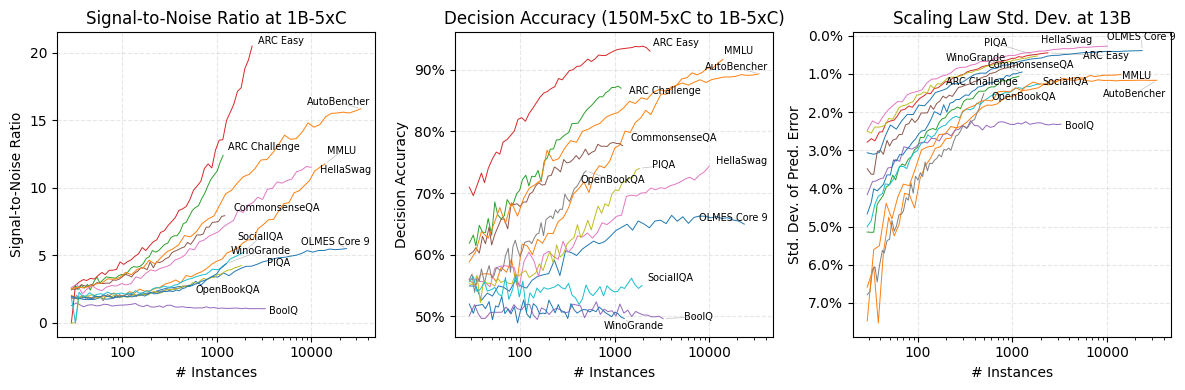

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# axins = ax3.inset_axes([0.4, 0.1, 0.55, 0.35])

ax1: plt.Axes
ax2: plt.Axes
ax3: plt.Axes

texts1, texts2, texts3, textsins = [], [], [], []
for task in plotted_tasks:
    task_name = get_title_from_task(task)
    if task_name not in task_data:
        continue

    if task_name in [
        'codex_humaneval',
        'codex_humanevalplus',
        'jeopardy',
        'gsm8k',
        'minerva_math_500',
        'minerva',
        'squad',
        'triviaqa',
        'drop'
    ]:
        continue
    

    data = task_data[task_name]
    pretty_name = get_pretty_task_name(task)
    
    ax1.plot(data['sizes'], data['snrs'], label=pretty_name, linewidth=0.7)
    ax2.plot(data['sizes'], data['accs'], label=pretty_name, linewidth=0.7)
    ax3.plot(data['sizes'], data['errors'], label=pretty_name, linewidth=0.7)
    axins.plot(data['sizes'], data['errors'], linewidth=0.7)

    texts1.append(ax1.text(data['sizes'][-1], data['snrs'][-1], pretty_name, fontsize=7))
    texts2.append(ax2.text(data['sizes'][-1], data['accs'][-1], pretty_name, fontsize=7))
    texts3.append(ax3.text(data['sizes'][-1], data['errors'][-1], pretty_name, fontsize=7))
    textsins.append(axins.text(data['sizes'][-1], data['errors'][-1], pretty_name, fontsize=7))

ax1.set_xlabel('# Instances')
ax1.set_ylabel('Signal-to-Noise Ratio')
ax1.set_title('Signal-to-Noise Ratio at 1B-5xC')
ax1.set_xscale('log')
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))

ax2.set_xlabel('# Instances')
ax2.set_ylabel('Decision Accuracy')
ax2.set_title('Decision Accuracy (150M-5xC to 1B-5xC)')
ax2.set_xscale('log')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

ax3.set_xlabel('# Instances')
ax3.set_ylabel(r'Std. Dev. of Pred. Error')
ax3.set_title('Scaling Law Std. Dev. at 13B')
ax3.set_xscale('log')
ax3.invert_yaxis()
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    
# axins.set_xlim(1000, max(data['sizes'])*1.1)
# axins.set_ylim(0.005, 0.001)
# axins.set_xscale('log')
# axins.grid(True, which='major', linestyle='--', alpha=0.3)
# axins.set_xticklabels([])
# axins.tick_params(axis='both', which='minor', labelsize=0)
# axins.tick_params(axis='x', labelbottom=False)
# axins.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
# axins.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
# ax3.indicate_inset_zoom(axins, edgecolor="black")
# adjustText(axins, textsins)

adjustText(ax1, texts1)
adjustText(ax2, texts2)
adjustText(ax3, texts3)

ax1.grid(True, which='major', linestyle='--', alpha=0.3)
ax2.grid(True, which='major', linestyle='--', alpha=0.3)
ax3.grid(True, which='major', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(Path(PLOT_DIR) / 'sample_size_error.pdf', bbox_inches='tight')
plt.show()